# GEDI Level 2B Vertical Plant Profiles - Dask Integration Test

**goal**: examine use of dask for gedipy

This notebook compares performance of pygedi numpy and dask.array backends for retrieving vertical plant profiles. The GEDI Level 2B product provides vertical cover, plant area index (PAI) and plant area volume density (PAVD) profiles at a vertical resolution of 5 m. In the following we retrieve the directional gap probability (Pgap) profile from the Level 2B product using GEDIPy with a dask backend, compute these vertical profile metrics at the vertical resolution of the original Level 1B waveform, and then visualize them.

**Notes**:
* this notebook cannot be run top to bottom, stored memory has to be monitored through dask dashboard
* the notebook has been developed for 2 cores wiht a max of 4GB in memory, use for larger systems have to be examined

**set-up**:
* in order ot use the [memory_profiler magic](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html) you need to `pip/conda install memory_profiler`

**first takeaways**:
* numba for performance quicker to implement than dask and helps in 99% of cases
* If results do not fit into memory, then it might be worth considering using dask, not calling `.compute()` but writing back to disk.
* refactoring the library for use of dask will be work intensive and requires indepth knowledge or testing of dask, chunking and memory storage and usage
* in case more performance is needed, instead of working on `dask.Arrays` it might be worth loading separate beams into `xarray.Datasets`. See: https://docs.dask.org/en/latest/array-best-practices.html
* if there is immediate need for allowing for bigger datasets & larger computations, gedipy's API might need to change in favor of a different processing approach, i.e. load beam into xarray and process form here with separate funcitons
* reading from hdf5 it is inefficient to create a np.array and load it into dask or xarray. Instead it is recommended to implement new methods, i.e. `.to_xarray()` or `.to_dask()` and rename `.read_shots` to `to_nparray()`

In [1]:
import pandas

import matplotlib.pyplot as plt
import ipywidgets

from gedipy import h5io
from dask import delayed, compute, visualize, config
from dask.distributed import Client, LocalCluster
import dask.array as da
import dask
import numpy as np


from numba import prange
from numba import jit
%load_ext memory_profiler

### Check dask global settings

First, we check the gloabl chunk size definition. This size is used when calling `chunks="auto"`

In [2]:
config.get('array.chunk-size')

'128MiB'

Working on a Laptop with `dask.Arrays` or `numpy.ndarrays` we make sure the sheduler is set to `'threads'`

In [3]:
# dask.config.set(scheduler='threads')

When using `dask.distributed` in order to use a threaded sheduler you can use the `processes=False` argument. The dask client helps to set up a dask dashboard. After running the next lines you can click on the provided link to monitor code performance on your system.

In [4]:
#client.close()

In [5]:
cluster = LocalCluster(processes=False)
client = Client(cluster)
client

Client Scheduler: inproc://10.0.2.15/5348/1 Dashboard: http://10.0.2.15:8787/status,Cluster Workers: 1 Cores: 2 Memory: 4.13 GB


## Open the H5 file
We select one of the power beams for this example

In [6]:
file_path_2B = "/home/stef/Testbed/00_data/GEDI/GEDI02_B_2019113083317_O02042_T04038_02_001_01.h5"

In [7]:
%%memit 
l2b_f = h5io.GEDIH5File(file_path_2B)

peak memory: 239.25 MiB, increment: 0.45 MiB


In [8]:
l2b_f.open_h5()
l2b_f.beams

['BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011']

In [9]:
l2b_f.fid.id.get_filesize()

1286863849

## Read all the profiles for one beam
This remaps the 1D pgap_theta_z array to a 2D M x N array, where M is the number Pgap profiles bins and N is the number of GEDI shots.

*pgap_theta_z* = Directional gap probability profile (pgap_theta_z = DN / 10000)
* gap fraction of a canopy is the fraction of view that is unobstructed in any particular angle
* probability that the ground surface is directly visible
* The profile is constant above canopy top = 1

### 1. Use of dask.delayed()?

First it is worth checking if a simple `dask.delayed()` call can be applied to current functionality in order to compute results lazily.

In [10]:
# Params
minlength=None
height=False #True
start_offset = 2
start=1
finish=None
chunks=True
beam = 'BEAM1011'

In [11]:
pgap_theta_z_da = delayed(l2b_f.read_pgap_theta_z)(beam, start=start, finish=finish, start_offset=start_offset)

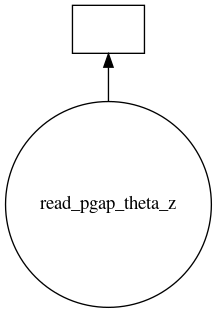

In [12]:
pgap_theta_z_da.visualize()

Inspecting the task graph reveals, as expected, that simply packing the funciton into a delayed call does not guarantee it beeing executed in parallel. Wrapping the current state of the function only has one delayed task, and so cannot parallelize. Ideally it woudl have ot be rewritten in smaller tasks, i.e. load data, process data and save data.

Let's now profile both versions. We can compare the output of `%memit`, as well as have a look at the Dashboard displaying `Dask: Status`.

In [13]:
%%memit 
pgap_theta_z_da.compute()

peak memory: 1633.91 MiB, increment: 1393.85 MiB


In [14]:
%%memit
# start_offset is used to buffer the start of the profile with pgap_theta_z = 1
pgap_theta_z = l2b_f.read_pgap_theta_z(beam, start=start, 
                                       finish=finish, height=height, 
                                       start_offset=start_offset)

peak memory: 1644.86 MiB, increment: 1398.02 MiB


Applying the function on the full dataset with `finish=None`, we can see both versions peak around  1600 MiB in memory, they basically perform the same. However, monitoring the dask dashboard reveales, that after calling dask delayed. Bytes stored returns back to 228 MB, while a normal function call now stores 1.6GB in Memory.

The advantage of using dask.delayed here is that stored data is automatically removed from memory, which is beneficial for continuing with other memory intensive computations.


### 2. Refactoring the code to make use of `dask.arrays`

In [11]:
@jit(nopython=True, parallel=True)
def _waveform_1d_to_2d_test(start_indices, counts, data, out_data, start_offset=0):
    for i in prange(len(start_indices)):
        for j in prange(counts[i]):
            out_data[j+start_offset, i] = data[start_indices[i] + j]
    return out_data

def _expand(x):
    return np.expand_dims(x, axis=0)

def _chunks(l2b_f, beam, key):
    """get hdf5 chunk size"""
    chunk_size = l2b_f.fid[beam+key].chunks
    return chunk_size
    
def _access_data(l2b_f, beam, key, start, finish, chunks=True):
    """load data into dask.array"""
    if chunks is True:
        chunk_size = _chunks(l2b_f, beam, key)
    else:
        chunk_size = chunks
    
    darr = da.from_array(l2b_f.fid[
        beam+key][start:finish], chunks=chunk_size)
    return darr

def _counts_index(l2b_f, finish=None, chunks=True):
    """"""
    start_indices_da = da.from_array(l2b_f.fid[
        beam+'/rx_sample_start_index'][start:finish]-1, chunks='auto')
    counts_da = _access_data(l2b_f,
                             beam=beam, key='/rx_sample_count', start=start,
                             finish=finish, chunks=chunks)

    max_count_da = counts_da.max() + start_offset

    start_indices, counts, max_count = compute(start_indices_da,
                                               counts_da, max_count_da,)
    return start_indices, counts, max_count

def read_pgap_theta_z_dask(l2b_f, beam, start=0, 
                           finish=None, minlength=None,
                           start_offset=0, 
                           chunks=True):
    """
    Remap the 1D pgap_theta_z array to a 2D M x N array, where M is
    the number Pgap profiles bins and N is the number of GEDI shots

    Parameters
    ----------
    beam: str
        Name of beam assessed, i.e. 'BEAM0001'
    start: int
        start of np.ndarray like slicing, Default=0
    finish: int/ None
        end of np.ndarray like slicing, Default=None
    minlength int:
        Minimum value for M
        Default is the maximum pgap_theta_z array length
    start_offset: int
        Offset the start each profile in out_pgap_profile by
        start_offset bins. These bins are filled with ones.
        Default = 0

    Returns
    -------
    out_pgap_profile: numpy.ndarray
        2D numpy.ndarray of read pgap_theta_z data
    """

    if not finish:
        finish = len(l2b_f.fid[beam+'/rx_sample_start_index'])
    else:
        pass
    
    # load all required variables
    start_indices, counts, max_count = _counts_index(l2b_f, 
                                                  finish=finish, 
                                                  chunks=chunks)
    pgap_da = _access_data(l2b_f, beam=beam, key='/pgap_theta', start=start,
                           finish=finish, chunks=chunks)
    pgap_profile_da = da.from_array(l2b_f.fid[beam+'/pgap_theta_z'][
        start_indices[0]:(
            start_indices[-1]+counts[-1])],
                                    chunks=_chunks(l2b_f, 
                                                   beam=beam, 
                                                   key='/pgap_theta_z'))
    
    # Calculate final shape
    if minlength:
        max_count = max(minlength, max_count)
    out_shape = (max_count-start_offset, len(counts))
    
    # Broadcast out_pgap_profile_da to final shape
    out_pgap_profile_da = da.broadcast_to(pgap_da, (out_shape))
    
    # Create offset layer
    if start_offset:
        out_pgap_profile_da = da.pad(
            out_pgap_profile_da, [(start_offset,0),(0,0)],
            'constant', constant_values = 1.)
    else:
        pass
    
    # calculate start_indices for 2D
    start_indices_wv = start_indices - start_indices.min()
    
    # compute 1D pgap_profile
    pgap_profile, out_pgap_profile = compute(
        pgap_profile_da, out_pgap_profile_da)
    
    # remap to 2D
    pgap_profile_out = _waveform_1d_to_2d_test(start_indices_wv,
                                          counts, pgap_profile,
                                          out_pgap_profile,
                                          start_offset=start_offset)
    return pgap_profile_out

    
def height_pgap_theta_z(l2b_f, beam, start, finish=None,
                        minlength=None,
                        chunks=True):
    """Calculate height"""
    # load data
    height_bin0 = _access_data(l2b_f=l2b_f, 
                               beam=beam, key='/geolocation/height_bin0',
                               start=start, finish=finish, chunks=chunks)
    height_lastbin = _access_data(l2b_f=l2b_f,
                                  beam=beam, key='/geolocation/height_lastbin',
                                  start=start, finish=finish, chunks=chunks)
    counts_da = _access_data(l2b_f=l2b_f,
                             beam=beam, key='/rx_sample_count', start=start,
                             finish=finish, chunks=chunks)
    _,_, max_count = _counts_index(l2b_f, finish=finish, chunks=chunks)
    
    if minlength:
        max_count = max(minlength, max_count)
    
    v = (height_bin0 - height_lastbin) / (counts_da - 1)
    bin_dist = da.arange(max_count).reshape([-1,1])
    out_height = height_bin0 - bin_dist * v + start_offset * v

    return out_height.compute()


### results for pgap_theta_z

In [12]:
finish=80000

In [13]:
%%memit
# start_offset is used to buffer the start of the profile with pgap_theta_z = 1
pgap_theta_z_dask = read_pgap_theta_z_dask(l2b_f, beam, start=start, 
                                           finish=finish,
                                           start_offset=start_offset,
                                           chunks=True)

peak memory: 608.72 MiB, increment: 369.02 MiB


In [13]:
%%memit
# start_offset is used to buffer the start of the profile with pgap_theta_z = 1
pgap_theta_z = l2b_f.read_pgap_theta_z(beam, start=start, 
                                       finish=finish, height=height, 
                                       start_offset=start_offset)

peak memory: 587.36 MiB, increment: 346.90 MiB


In [15]:
pgap_theta_z.shape

(1003, 79999)

In [16]:
pgap_theta_z_dask.shape

(1003, 79999)

In [17]:
if pgap_theta_z.all() == pgap_theta_z_dask.all():
    print("Results are the same")

Results are the same


Abandoning for now, using `dask.Arrays` for calculating out_pgap_profile does not seem to outperform current implementation. Potential reasons could be:
* chunking needs to be further optimized
* `_waveform_1d_to_2d` currently contains heavy duty computation and is already optimized with numba. Interesting option would be to optimize `_waveform_1d_to_2d` and make it work for larger than memory datasets. (Longer term project)

### results for height

In [14]:
finish=90000

In [13]:
%%memit
out_height_dask = height_pgap_theta_z(l2b_f, beam, 
                                            start=start, 
                                            finish=finish,
                                            chunks=True)

peak memory: 1361.95 MiB, increment: 1120.99 MiB


In [13]:
%%memit
# start_offset is used to buffer the start of the profile with pgap_theta_z = 1
_, out_height = l2b_f.read_pgap_theta_z(beam, start=start, 
                                       finish=finish, height=True, 
                                       start_offset=start_offset)

peak memory: 1737.47 MiB, increment: 1500.39 MiB


In [15]:
out_height_dask.shape

(1003, 79999)

In [16]:
out_height.shape

(1003, 79999)

In [18]:
if out_height.all() == out_height_dask.all():
    print("Results are the same")

Results are the same


Computation is faster and more memory efficient for height above ground of each profile bin. Not clear yet whether this is due to dask or general refactoring of the functionality, relying on automatic broadcasting. Changes could be included in current funcitonality nevertheless

## Development Notes: Step through one by one

In [15]:
if not finish:
    finish = len(l2b_f.fid[beam+'/rx_sample_start_index'])
else:
    pass
finish

90000

In [16]:
x = _chunks(l2b_f, beam=beam, key='/rx_sample_count')
x

(14200,)

In [17]:
counts_da = _access_data(l2b_f, beam=beam, key='/rx_sample_count',
                         start=start,finish=finish, chunks=chunks)
pgap_da = _access_data(l2b_f, beam=beam, key='/pgap_theta', start=start,
                       finish=finish, chunks=chunks)

In [18]:
counts_da

dask.array<array, shape=(89999,), dtype=int64, chunksize=(14200,), chunktype=numpy.ndarray>

In [19]:
pgap_da

dask.array<array, shape=(89999,), dtype=float32, chunksize=(14200,), chunktype=numpy.ndarray>

In [22]:
start_indices_da = da.from_array(l2b_f.fid[
    beam+'/rx_sample_start_index'][start:finish]-1,
                                 chunks=_chunks(
                                     l2b_f, beam, key='/rx_sample_start_index'))

In [23]:
start_indices_da

dask.array<array, shape=(89999,), dtype=int64, chunksize=(14200,), chunktype=numpy.ndarray>

In [24]:
max_count_da = counts_da.max() + start_offset

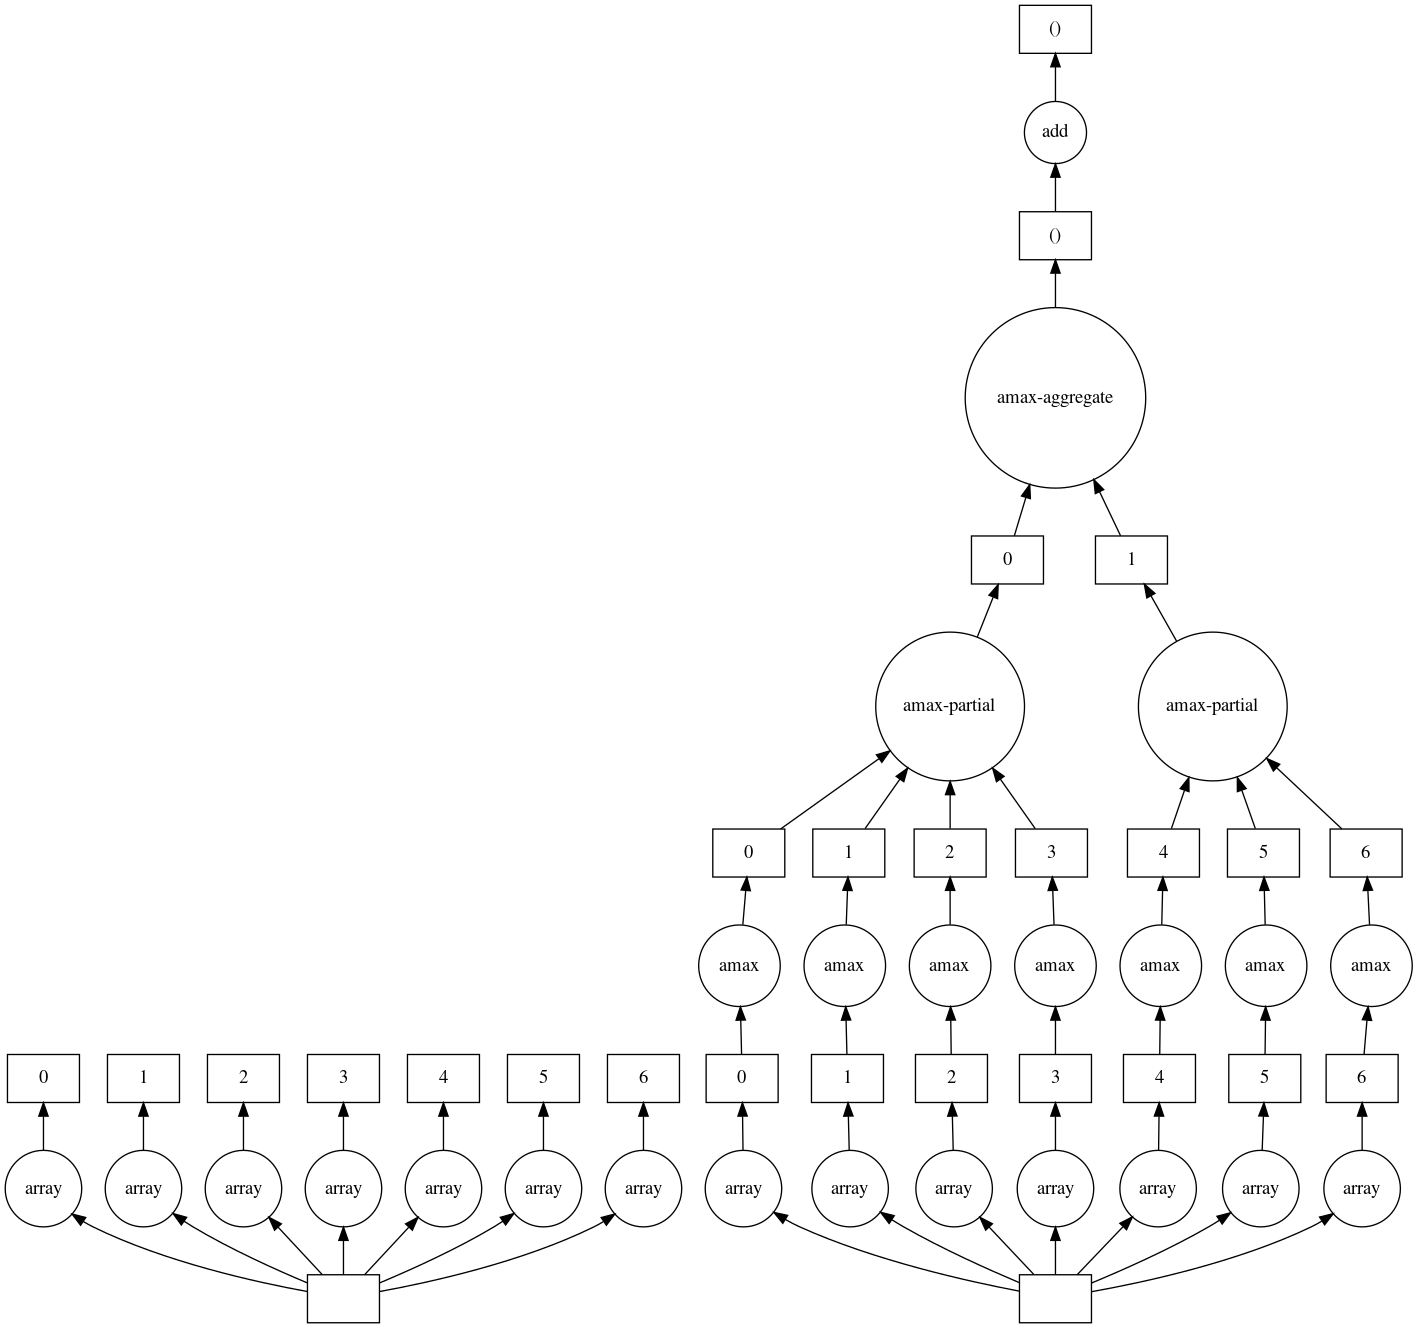

In [25]:
visualize(start_indices_da,counts_da, max_count_da)

In [26]:
start_indices, counts, max_count= compute(start_indices_da,
                                          counts_da, max_count_da)

In [28]:
pgap_profile_da = da.from_array(l2b_f.fid[beam+'/pgap_theta_z'][
            start_indices[0]:(start_indices[-1]+counts[-1])],
                                chunks=_chunks(l2b_f, beam, key='/pgap_theta_z'))
pgap_profile_da

,Array,Chunk
Bytes,20.94 MB,56.80 kB
Shape,"(5235223,)","(14200,)"
Count,370 Tasks,369 Chunks
Type,float32,numpy.ndarray


In [29]:
if minlength:
    max_count = max(minlength, max_count)
            
out_shape = (max_count-start_offset, len(counts))

In [30]:
out_shape

(1001, 89999)

In [31]:
pgap_da_broadcast = da.broadcast_to(pgap_da, (out_shape))

In [32]:
pgap_da_broadcast

dask.array<broadcast_to, shape=(1001, 89999), dtype=float32, chunksize=(1001, 14200), chunktype=numpy.ndarray>

In [34]:
out_pgap_profile_da = da.pad(pgap_da_broadcast, [(start_offset,0),(0,0)],
                             'constant', constant_values = 1.)

In [35]:
out_pgap_profile_da

dask.array<concatenate, shape=(1003, 89999), dtype=float32, chunksize=(1001, 14200), chunktype=numpy.ndarray>

In [36]:
start_indices_wv_da = start_indices_da - start_indices_da.min()

In [37]:
start_indices_wv, pgap_profile, out_pgap_profile = compute(
    start_indices_wv_da, pgap_profile_da, out_pgap_profile_da)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.823312 to fit


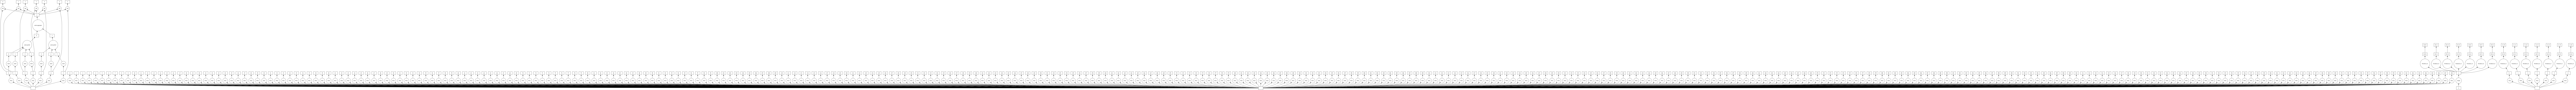

In [38]:
visualize(start_indices_wv_da, pgap_profile_da, out_pgap_profile_da)

In [41]:
out_data = delayed(_waveform_1d_to_2d_test)(start_indices_wv, counts, pgap_profile,
                               out_pgap_profile, start_offset=start_offset)

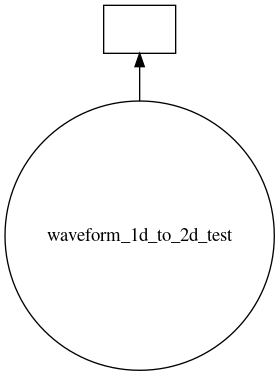

In [42]:
out_data.visualize()

In [ ]:
out_data.compute()

## PROBLEM with Height

In [15]:
#start=0
finish=None

In [16]:
chunks=True

In [17]:
height_bin0 = _access_data(l2b_f, beam=beam, key='/geolocation/height_bin0',
                               start=start, finish=finish, chunks=True)

In [18]:
 height_bin0

dask.array<array, shape=(343170,), dtype=float32, chunksize=(14200,), chunktype=numpy.ndarray>

In [19]:
height_lastbin = _access_data(l2b_f, beam=beam, key='/geolocation/height_lastbin',
                              start=start, finish=finish, chunks=chunks)

In [20]:
height_lastbin

dask.array<array, shape=(343170,), dtype=float32, chunksize=(14200,), chunktype=numpy.ndarray>

In [21]:
counts_da = _access_data(l2b_f, beam=beam, key='/rx_sample_count',
                         start=start, finish=finish, chunks=chunks)

In [22]:
counts_da

dask.array<array, shape=(343170,), dtype=int64, chunksize=(14200,), chunktype=numpy.ndarray>

In [23]:
v = (height_bin0 - height_lastbin) / (counts_da - 1)

In [24]:
v

dask.array<truediv, shape=(343170,), dtype=float64, chunksize=(14200,), chunktype=numpy.ndarray>

In [25]:
max_count_da = counts_da.max() + start_offset

In [26]:
max_count_da

dask.array<add, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>

In [27]:
bin_dis = da.arange(max_count_da).reshape([-1,1])

In [28]:
bin_dis

dask.array<reshape, shape=(1004, 1), dtype=int64, chunksize=(1004, 1), chunktype=numpy.ndarray>

In [29]:
out_height = height_bin0 - bin_dis * v + start_offset * v

In [30]:
out_height

dask.array<add, shape=(1004, 343170), dtype=float64, chunksize=(1004, 14200), chunktype=numpy.ndarray>

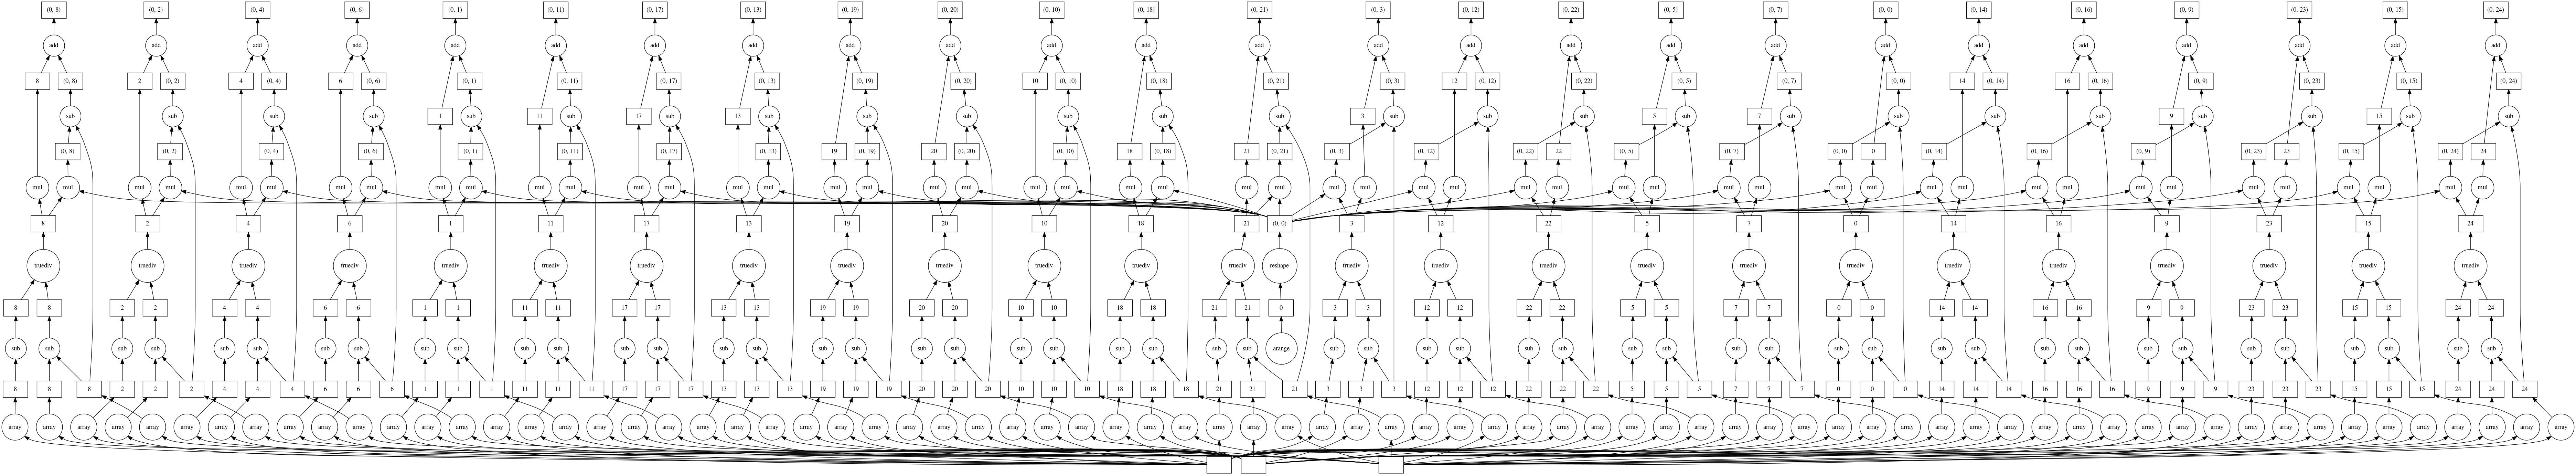

In [31]:
out_height.visualize()

In [ ]:
out_height.compute()